In [107]:
import math
import typing as ty
import numpy as np
import pandas as pd
import torch
import torch.nn as nn
import torch.nn.functional as F
from torch import Tensor
from torch.utils.data import Dataset, DataLoader
from sklearn.preprocessing import StandardScaler
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, balanced_accuracy_score, mean_squared_error, r2_score
import matplotlib.pyplot as plt
import os
import json
import requests
import zipfile
import io
from tqdm import tqdm

In [108]:
torch.manual_seed(42)
np.random.seed(42)

In [109]:
class MLP(nn.Module):  # из гитхаба
    def __init__(
        self,
        *,
        d_in: int,
        d_out: int,
        d_layers: ty.List[int],
        dropout: float,

        ) -> None:
        super().__init__()
        self.dropout = dropout
        self.d_out = d_out
        self.layers = nn.ModuleList(
            [
                nn.Linear(d_layers[i - 1] if i else d_in, x)
                for i, x in enumerate(d_layers)
            ]
        )
        self.head = nn.Linear(d_layers[-1] if d_layers else d_in, d_out)
    def forward(self, x, x_cat = None):
        for layer in self.layers:
            x = layer(x)
            x = F.relu(x)
            if self.dropout:
                x = F.dropout(x, self.dropout, self.training)
        logit = self.head(x)
        if self.d_out == 1:
            logit = logit.squeeze(-1)
        return logit

In [110]:
# из гитхаба
def reglu(x):
    a, b = x.chunk(2, dim=-1)
    return a * F.relu(b)

def geglu(x):
    a, b = x.chunk(2, dim=-1)
    return a * F.gelu(b)

def get_nonglu_activation_fn(name):
    return (
        F.relu
        if name == 'reglu'
        else F.gelu
        if name == 'geglu'
        else get_activation_fn(name)
    )

def get_activation_fn(name):
    return (
        reglu
        if name == 'reglu'
        else geglu
        if name == 'geglu'
        else torch.sigmoid
        if name == 'sigmoid'
        else getattr(F, name)
    )

class ResNet(nn.Module):
    def __init__(
        self,
        *,
        d_in: int,
        d: int,
        d_hidden_factor: float,
        n_layers: int,
        activation: str,
        normalization: str,
        hidden_dropout: float,
        residual_dropout: float,
        d_out: int,
        use_normalization: bool = True,
        use_residual: bool = True,
        ) -> None:
        super().__init__()

        def make_normalization():
            if normalization == 'batchnorm':
                return nn.BatchNorm1d(d)
            elif normalization == 'layernorm':
                return nn.LayerNorm(d)
            elif normalization == 'instancenorm':
                return nn.InstanceNorm1d(d)
            elif normalization == 'groupnorm':
                return nn.GroupNorm(min(32, d), d)
            else:
                return nn.Identity()

        self.main_activation = get_activation_fn(activation)
        self.last_activation = get_nonglu_activation_fn(activation)
        self.residual_dropout = residual_dropout
        self.hidden_dropout = hidden_dropout
        self.use_normalization = use_normalization
        self.use_residual = use_residual
        self.d_out = d_out

        d_hidden = int(d * d_hidden_factor)
        self.first_layer = nn.Linear(d_in, d)

        self.layers = nn.ModuleList(
            [
                nn.ModuleDict(
                    {
                        'norm': make_normalization(),
                        'linear0': nn.Linear(
                            d, d_hidden * (2 if activation.endswith('glu') else 1)
                            ),
                        'linear1': nn.Linear(d_hidden, d),
                    }
                )
                for _ in range(n_layers)
            ]
        )

        self.last_normalization = make_normalization() if use_normalization else nn.Identity()
        self.head = nn.Linear(d, d_out)

    def forward(self, x: Tensor, x_cat=None) -> Tensor:
        x = self.first_layer(x)

        for layer in self.layers:
            layer = ty.cast(ty.Dict[str, nn.Module], layer)
            z = x

            if self.use_normalization:
                z = layer['norm'](z)

            z = layer['linear0'](z)
            z = self.main_activation(z)

            if self.hidden_dropout:
                z = F.dropout(z, self.hidden_dropout, self.training)

            z = layer['linear1'](z)

            if self.residual_dropout:
                z = F.dropout(z, self.residual_dropout, self.training)

            if self.use_residual:
                x = x + z
            else:
                x = z

        if self.use_normalization:
            x = self.last_normalization(x)

        x = self.last_activation(x)
        x = self.head(x)

        if self.d_out == 1:
            x = x.squeeze(-1)

        return x

In [111]:
class TabularDataset(Dataset):  # для работы с табличными данными в формате тензоров торч
    def __init__(self, X, y):
        self.X = X
        self.y = y

    def __len__(self):
        return len(self.X)

    def __getitem__(self, idx):
        return self.X[idx], self.y[idx]

In [112]:
# Функция для проверки , что датасет существует в локальной директории
def check_dataset(dataset_name, data_path='data'):
    dataset_dir = os.path.join(data_path, dataset_name)
    if not os.path.exists(dataset_dir):
        return False

    if not os.path.exists(os.path.join(dataset_dir, 'info.json')):
        return False

    if not (os.path.exists(os.path.join(dataset_dir, 'y_train.npy')) and
            os.path.exists(os.path.join(dataset_dir, 'y_val.npy')) and
            os.path.exists(os.path.join(dataset_dir, 'y_test.npy'))):
        return False

    return True

In [113]:
# Функция для загрузки датасета из локальной директории
def load_dataset(dataset_name, data_path='../data'):
    dataset_dir = os.path.join(data_path, dataset_name)

    # Загружаем info.json, чтобы узнать тип задачи+признаки
    with open(os.path.join(dataset_dir, 'info.json'), 'r') as f:
        info = json.load(f)

    task_type = info['task_type']  # Тип задачи: 'regression', 'binclass', 'multiclass'
    n_num_features = info.get('n_num_features', 0)  # Количество числовых признаков
    n_cat_features = info.get('n_cat_features', 0)  # Количество категориальных признаков

    # Загружаем метки
    y_train = np.load(os.path.join(dataset_dir, 'y_train.npy'))
    y_val = np.load(os.path.join(dataset_dir, 'y_val.npy'))
    y_test = np.load(os.path.join(dataset_dir, 'y_test.npy'))

    # Инициализируем массивы признаков
    X_train = []
    X_val = []
    X_test = []

    # Загружаем числовые признаки, если они есть
    if n_num_features > 0:
        if os.path.exists(os.path.join(dataset_dir, 'N_train.npy')):
            N_train = np.load(os.path.join(dataset_dir, 'N_train.npy'))
            N_val = np.load(os.path.join(dataset_dir, 'N_val.npy'))
            N_test = np.load(os.path.join(dataset_dir, 'N_test.npy'))

            X_train.append(N_train)
            X_val.append(N_val)
            X_test.append(N_test)

    # Загружаем категориальные признаки, если они есть
    if n_cat_features > 0:
        if os.path.exists(os.path.join(dataset_dir, 'C_train.npy')):
            C_train = np.load(os.path.join(dataset_dir, 'C_train.npy'))
            C_val = np.load(os.path.join(dataset_dir, 'C_val.npy'))
            C_test = np.load(os.path.join(dataset_dir, 'C_test.npy'))

            X_train.append(C_train)
            X_val.append(C_val)
            X_test.append(C_test)

    # Объединяем признаки, если есть и числовые, и категориальные
    if len(X_train) > 1:
        X_train = np.concatenate(X_train, axis=1)  # Объединяем по столбцам
        X_val = np.concatenate(X_val, axis=1)
        X_test = np.concatenate(X_test, axis=1)
    elif len(X_train) == 1:
        X_train = X_train[0]  # Если только один тип признаков, берем его
        X_val = X_val[0]
        X_test = X_test[0]
    else:
        raise ValueError(f"Не найдены признаки для датасета {dataset_name}")

    print(f"Датасет {dataset_name} загружен")

    return {
        'X_train': X_train,
        'X_val': X_val,
        'X_test': X_test,
        'y_train': y_train,
        'y_val': y_val,
        'y_test': y_test,
        'task_type': task_type,
        'n_num_features': n_num_features,
        'n_cat_features': n_cat_features,
        'n_features': X_train.shape[1]
    }

In [114]:
# Функция предобработки данных, уже разделенных на train/val/test
def preprocess_data(dataset_info):
    X_train = dataset_info['X_train']
    X_val = dataset_info['X_val']
    X_test = dataset_info['X_test']
    y_train = dataset_info['y_train']
    y_val = dataset_info['y_val']
    y_test = dataset_info['y_test']
    task_type = dataset_info['task_type']
    n_features = dataset_info['n_features']

    # Нормализуем числовые признаки
    scaler = StandardScaler()
    X_train_scaled = scaler.fit_transform(X_train)  # Обучаем скейлер только на тренировочных данных
    X_val_scaled = scaler.transform(X_val)  # Применяем скейлер к валидационным данным
    X_test_scaled = scaler.transform(X_test)  # Применяем скейлер к тестовым данным

    # Определяем количество классов для задач классификации
    if task_type == 'binclass':
        task_type = 'classification'  # Стандартизируем название
        num_classes = 1  # Бинарная классификация (один выход)
    elif task_type == 'multiclass':
        task_type = 'classification'  # Стандартизируем название
        num_classes = len(np.unique(np.concatenate([y_train, y_val, y_test])))
    else:  # regression
        num_classes = 1

    # Преобразуем в тензоры PyTorch
    X_train_tensor = torch.FloatTensor(X_train_scaled)
    X_val_tensor = torch.FloatTensor(X_val_scaled)
    X_test_tensor = torch.FloatTensor(X_test_scaled)

    # Преобразуем метки в зависимости от типа задачи
    if task_type == 'classification':
        if num_classes > 1:
            y_train_tensor = torch.LongTensor(y_train.flatten())
            y_val_tensor = torch.LongTensor(y_val.flatten())
            y_test_tensor = torch.LongTensor(y_test.flatten())
        else:
            y_train_tensor = torch.FloatTensor(y_train.flatten())
            y_val_tensor = torch.FloatTensor(y_val.flatten())
            y_test_tensor = torch.FloatTensor(y_test.flatten())
    else:
        y_train_tensor = torch.FloatTensor(y_train.flatten())
        y_val_tensor = torch.FloatTensor(y_val.flatten())
        y_test_tensor = torch.FloatTensor(y_test.flatten())

    train_dataset = TabularDataset(X_train_tensor, y_train_tensor)
    val_dataset = TabularDataset(X_val_tensor, y_val_tensor)
    test_dataset = TabularDataset(X_test_tensor, y_test_tensor)

    return {
        'train_dataset': train_dataset,
        'val_dataset': val_dataset,
        'test_dataset': test_dataset,
        'num_features': n_features,
        'num_classes': num_classes,
        'task_type': task_type
    }

In [115]:
# Функция обучения модели с ранней остановкой
def train_model(model, train_loader, test_loader, criterion, optimizer, device,
                task_type=None, epochs=100, patience=10, verbose=False):
    model.to(device)

    best_loss = float('inf')  # Лучшее значение функции потерь
    best_model_state = None  # Лучшее состояние модели
    patience_counter = 0  # Счетчик для ранней остановки
    train_losses = []  # История функции потерь на обучающей выборке
    test_losses = []  # История функции потерь на валидационной выборке

    for epoch in range(epochs):
        model.train()
        running_loss = 0.0

        for inputs, targets in train_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Обнуляем градиенты
            optimizer.zero_grad()

            # Прямой проход
            outputs = model(inputs)

            if task_type == 'classification' and model.d_out > 1:
                loss = criterion(outputs, targets)
            else:
                loss = criterion(outputs, targets.float())

            # Обратный проход и оптимизация
            loss.backward()
            optimizer.step()

            running_loss += loss.item() * inputs.size(0)

        # Вычисляем среднюю функцию потерь на эпохе
        epoch_train_loss = running_loss / len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Валидация
        model.eval()  # Переключаем модель в режим оценки
        running_loss = 0.0

        with torch.no_grad():  # Отключаем расчет градиентов
            for inputs, targets in test_loader:
                inputs, targets = inputs.to(device), targets.to(device)

                # Прямой проход
                outputs = model(inputs)

                # Вычисляем функцию потерь
                if task_type == 'classification' and model.d_out > 1:
                    loss = criterion(outputs, targets)
                else:
                    loss = criterion(outputs, targets.float())

                running_loss += loss.item() * inputs.size(0)

        # Вычисляем среднюю функцию потерь на валидации
        epoch_test_loss = running_loss / len(test_loader.dataset)
        test_losses.append(epoch_test_loss)

        # Ранняя остановка
        if epoch_test_loss < best_loss:
            best_loss = epoch_test_loss
            best_model_state = model.state_dict().copy()  # Сохраняем лучшую модель
            patience_counter = 0
        else:
            patience_counter += 1
            if patience_counter >= patience:
                if verbose:
                    print(f"Ранняя остановка на эпохе {epoch+1}")
                break

        if verbose and (epoch + 1) % 10 == 0:
            print(f"Эпоха {epoch+1}/{epochs}, Потери на обучении: {epoch_train_loss:.4f}, Потери на валидации: {epoch_test_loss:.4f}")

    model.load_state_dict(best_model_state)

    return {
        'model': model,
        'train_losses': train_losses,
        'test_losses': test_losses,
        'best_loss': best_loss
    }

In [116]:
# Функция оценки качества модели
def evaluate_model(model, test_loader, task_type, device):
    model.to(device)
    model.eval()

    all_preds = []  # Список для хранения предсказаний
    all_targets = []  # Список для хранения истинных меток

    with torch.no_grad():  # Отключаем расчет градиентов для экономии памяти
        for inputs, targets in test_loader:
            inputs, targets = inputs.to(device), targets.to(device)

            # Прямой проход
            outputs = model(inputs)

            # Получаем предсказания
            if task_type == 'classification':
                if model.d_out > 1:
                    _, preds = torch.max(outputs, 1)  # Индекс класса с наибольшей вероятностью
                else:
                    preds = (torch.sigmoid(outputs) > 0.5).float()  # Пороговое значение 0.5
            else:
                preds = outputs

            # Сохраняем предсказания и истинные метки
            all_preds.extend(preds.cpu().numpy())
            all_targets.extend(targets.cpu().numpy())

    all_preds = np.array(all_preds)
    all_targets = np.array(all_targets)

    # Вычисляем метрики в зависимости от типа задачи
    metrics = {}
    if task_type == 'classification':
        metrics['accuracy'] = accuracy_score(all_targets, all_preds)
        if len(np.unique(all_targets)) > 2:
            metrics['balanced_accuracy'] = balanced_accuracy_score(all_targets, all_preds)
    else:
        metrics['mse'] = mean_squared_error(all_targets, all_preds)
        metrics['r2'] = r2_score(all_targets, all_preds)

    return metrics

In [117]:
def run_experiments(dataset_info, model_configs, device, batch_size=64, lr=0.001):
    task_type = dataset_info['task_type']
    train_dataset = dataset_info['train_dataset']
    test_dataset = dataset_info['test_dataset']
    num_features = dataset_info['num_features']
    num_classes = dataset_info['num_classes']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    if task_type == 'classification':
        if num_classes > 2:
            criterion = nn.CrossEntropyLoss()
        else:
            criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.MSELoss()

    results = {}

    for name, config in model_configs.items():
        print(f"\nTraining {name}...")

        # Создаем модель
        if config['model_type'] == 'mlp':
            model = MLP(
                d_in=num_features,
                d_out=num_classes if task_type == 'classification' and num_classes > 2 else 1,
                d_layers=config['d_layers'],
                dropout=config['dropout']
            )
        else:  # resnet
            model = ResNet(
                d_in=num_features,
                d=config['d'],
                d_hidden_factor=config['d_hidden_factor'],
                n_layers=config['n_layers'],
                activation=config['activation'],
                normalization=config['normalization'],
                hidden_dropout=config['hidden_dropout'],
                residual_dropout=config['residual_dropout'],
                d_out=num_classes if task_type == 'classification' and num_classes > 2 else 1,
                use_normalization=config['use_normalization'],
                use_residual=config['use_residual']
            )

        # Создаем оптимизатор
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        train_results = train_model(
            model=model,
            train_loader=train_loader,
            test_loader=test_loader,
            criterion=criterion,
            optimizer=optimizer,
            task_type=task_type,
            device=device,
            verbose=True
        )

        eval_metrics = evaluate_model(
            model=train_results['model'],
            test_loader=test_loader,
            task_type=task_type,
            device=device
        )

        results[name] = {
            'train_losses': train_results['train_losses'],
            'test_losses': train_results['test_losses'],
            'metrics': eval_metrics
        }

        print(f"Results for {name}:")
        for metric_name, metric_value in eval_metrics.items():
            print(f"  {metric_name}: {metric_value:.4f}")

    return results

In [118]:
# Функция визуализации результатов экспериментов
def plot_results(results, task_type, dataset_name):
    # Рисуем графики обучения
    plt.figure(figsize=(15, 5))

    # График функции потерь на обучающей выборке
    plt.subplot(1, 2, 1)
    for name, result in results.items():
        plt.plot(result['train_losses'], label=name)
    plt.title(f'Функция потерь на обучающей выборке - {dataset_name}')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend()

    # График функции потерь на валидационной выборке
    plt.subplot(1, 2, 2)
    for name, result in results.items():
        # Проверяем какой ключ доступен для совместимости
        if 'val_losses' in result:
            val_key = 'val_losses'
        else:
            val_key = 'test_losses'
        plt.plot(result[val_key], label=name)
    plt.title(f'Функция потерь на валидационной выборке - {dataset_name}')
    plt.xlabel('Эпоха')
    plt.ylabel('Потери')
    plt.legend()

    plt.tight_layout()
    plt.savefig(f'{dataset_name}_losses.png')
    plt.show()

    # Получаем доступные метрики (проверяем по первому результату)
    first_result = next(iter(results.values()))
    available_metrics = list(first_result['metrics'].keys())

    # Определяем, какие метрики визуализировать
    if task_type == 'classification':
        if 'balanced_accuracy' in available_metrics:
            metric_names = ['accuracy', 'balanced_accuracy']
        else:
            metric_names = ['accuracy']
    else:
        metric_names = [m for m in ['mse', 'r2'] if m in available_metrics]

    # Визуализируем метрики, только если они доступны
    if metric_names:
        plt.figure(figsize=(15, 5))

        for i, metric_name in enumerate(metric_names):
            plt.subplot(1, len(metric_names), i+1)

            values = []
            for name, result in results.items():
                if metric_name in result['metrics']:
                    values.append(result['metrics'][metric_name])
                else:
                    print(f"Предупреждение: метрика {metric_name} не найдена для {name}, используем 0")
                    values.append(0)

            bars = plt.bar(results.keys(), values)

            plt.title(f'{metric_name.replace("_", " ").title()} - {dataset_name}')
            plt.xlabel('Модель')
            plt.ylabel(metric_name)
            plt.xticks(rotation=45)

            for bar in bars:
                height = bar.get_height()
                plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
                        f'{height:.4f}', ha='center', va='bottom', rotation=0)

        plt.tight_layout()
        plt.savefig(f'{dataset_name}_metrics.png')
        plt.show()

In [119]:
def analyze_component_importance(all_results):
    dataset_summaries = {}

    for dataset_name, results_data in all_results.items():
        task_type = results_data['task_type']
        results = results_data['results']

        first_result_name = next(iter(results.keys()))
        available_metrics = list(results[first_result_name]['metrics'].keys())

        # Определяем основную метрику
        if task_type == 'classification':
            if 'balanced_accuracy' in available_metrics:
                primary_metric = 'balanced_accuracy'
            else:
                primary_metric = 'accuracy'
            higher_is_better = True
        else:  # regression
            if 'mse' in available_metrics:
                primary_metric = 'mse'
                higher_is_better = False
            else:
                primary_metric = 'r2'
                higher_is_better = True

        print(f"Используем {primary_metric} как основную метрику для {dataset_name}")

        # Проверяем, что все модели имеют основную метрику
        missing_metric = False
        for name, result in results.items():
            if primary_metric not in result['metrics']:
                print(f"Предупреждение: метрика {primary_metric} не найдена для {name} в {dataset_name}")
                missing_metric = True

        # Пропускаем датасет, если метрики отсутствуют
        if missing_metric:
            print(f"Пропускаем {dataset_name} из-за отсутствия метрик")
            continue

        # Получаем производительность базовой модели (MLP)
        if 'MLP' in results:
            baseline_metric = results['MLP']['metrics'][primary_metric]
        else:
            # Используем первую модель как базовую, если MLP отсутствует
            baseline_metric = results[first_result_name]['metrics'][primary_metric]

        # Вычисляем относительную производительность
        relative_performance = {}
        for name, result in results.items():
            metric_value = result['metrics'][primary_metric]

            # Вычисляем относительное улучшение по сравнению с базовой моделью
            if higher_is_better:
                rel_perf = (metric_value / baseline_metric) - 1.0 if baseline_metric != 0 else 0
            else:
                rel_perf = 1.0 - (metric_value / baseline_metric) if baseline_metric != 0 else 0

            relative_performance[name] = rel_perf

        dataset_summaries[dataset_name] = {
            'task_type': task_type,
            'primary_metric': primary_metric,
            'baseline_metric': baseline_metric,
            'relative_performance': relative_performance
        }

    # Вычисляем важность компонентов
    bn_impact = []
    residual_impact = []

    for dataset_name, summary in dataset_summaries.items():
        rel_perf = summary['relative_performance']

        # Вычисляем только если все необходимые модели существуют
        if 'ResNet_Full' in rel_perf and 'ResNet_No_BN' in rel_perf:
            # Эффект от удаления BatchNorm
            bn_effect = rel_perf['ResNet_Full'] - rel_perf['ResNet_No_BN']
            bn_impact.append(bn_effect)

        if 'ResNet_Full' in rel_perf and 'ResNet_No_Residual' in rel_perf:
            # Эффект от удаления residual connection
            residual_effect = rel_perf['ResNet_Full'] - rel_perf['ResNet_No_Residual']
            residual_impact.append(residual_effect)

    avg_bn_impact = np.mean(bn_impact) if bn_impact else 0
    avg_residual_impact = np.mean(residual_impact) if residual_impact else 0

    # Вычисляем влияние модификаций
    layernorm_impact = []  # Влияние замены BatchNorm на LayerNorm
    gelu_impact = []  # Влияние замены ReLU на GELU
    dropout_impact = []  # Влияние увеличения dropout

    for dataset_name, summary in dataset_summaries.items():
        rel_perf = summary['relative_performance']

        if 'ResNet_Full' in rel_perf and 'ResNet_LayerNorm' in rel_perf:
            ln_effect = rel_perf['ResNet_LayerNorm'] - rel_perf['ResNet_Full']
            layernorm_impact.append(ln_effect)

        if 'ResNet_Full' in rel_perf and 'ResNet_GELU' in rel_perf:
            gelu_effect = rel_perf['ResNet_GELU'] - rel_perf['ResNet_Full']
            gelu_impact.append(gelu_effect)

        if 'ResNet_Full' in rel_perf and 'ResNet_Higher_Dropout' in rel_perf:
            dropout_effect = rel_perf['ResNet_Higher_Dropout'] - rel_perf['ResNet_Full']
            dropout_impact.append(dropout_effect)

    # Вычисляем средние значения влияния модификаций
    avg_layernorm_impact = np.mean(layernorm_impact) if layernorm_impact else None
    avg_gelu_impact = np.mean(gelu_impact) if gelu_impact else None
    avg_dropout_impact = np.mean(dropout_impact) if dropout_impact else None

    return {
        'dataset_summaries': dataset_summaries,
        'bn_impact': avg_bn_impact,
        'residual_impact': avg_residual_impact,
        'layernorm_impact': avg_layernorm_impact,
        'gelu_impact': avg_gelu_impact,
        'dropout_impact': avg_dropout_impact
    }

In [120]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print(f"Using device: {device}")

Using device: cpu


In [121]:
# Функция для проверки , что датасет существует в локальной директории
def check_dataset(dataset_name, data_path='../data'):
    dataset_dir = os.path.join(data_path, dataset_name)
    if not os.path.exists(dataset_dir):
        return False

    if not os.path.exists(os.path.join(dataset_dir, 'info.json')):
        return False

    if not (os.path.exists(os.path.join(dataset_dir, 'y_train.npy')) and
            os.path.exists(os.path.join(dataset_dir, 'y_val.npy')) and
            os.path.exists(os.path.join(dataset_dir, 'y_test.npy'))):
        return False

    return True

datasets = ['wine', 'houses', 'Pumpkin_Seeds']
for dataset in datasets:
    if check_dataset(dataset):
        print(f"Датасет {dataset} существует в папке")
    else:
        print(f"Датасет {dataset} не существует в папке")

Датасет wine существует в папке
Датасет houses существует в папке
Датасет Pumpkin_Seeds существует в папке


In [122]:
model_configs = {
    'MLP': {
        'model_type': 'mlp',
        'd_layers': [128, 128],
        'dropout': 0.1
    },
    'ResNet_Full': {
        'model_type': 'resnet',
        'd': 128,
        'd_hidden_factor': 2.0,
        'n_layers': 3,
        'activation': 'relu',
        'normalization': 'batchnorm',
        'hidden_dropout': 0.1,
        'residual_dropout': 0.0,
        'use_normalization': True,
        'use_residual': True
    },
    'ResNet_No_BN': {
        'model_type': 'resnet',
        'd': 128,
        'd_hidden_factor': 2.0,
        'n_layers': 3,
        'activation': 'relu',
        'normalization': 'batchnorm',
        'hidden_dropout': 0.1,
        'residual_dropout': 0.0,
        'use_normalization': False,  # не используем BatchNorm
        'use_residual': True
    },
    'ResNet_No_Residual': {
        'model_type': 'resnet',
        'd': 128,
        'd_hidden_factor': 2.0,
        'n_layers': 3,
        'activation': 'relu',
        'normalization': 'batchnorm',
        'hidden_dropout': 0.1,
        'residual_dropout': 0.0,
        'use_normalization': True,
        'use_residual': False  # не используем Residual connections
    },
    'ResNet_No_BN_No_Residual': {
        'model_type': 'resnet',
        'd': 128,
        'd_hidden_factor': 2.0,
        'n_layers': 3,
        'activation': 'relu',
        'normalization': 'batchnorm',
        'hidden_dropout': 0.1,
        'residual_dropout': 0.0,
        'use_normalization': False,  # не используем BatchNorm
        'use_residual': False        # не используем Residual connections
    },
    # Модифицируем
    'ResNet_LayerNorm': {
        'model_type': 'resnet',
        'd': 128,
        'd_hidden_factor': 2.0,
        'n_layers': 3,
        'activation': 'relu',
        'normalization': 'layernorm',
        'hidden_dropout': 0.1,
        'residual_dropout': 0.0,
        'use_normalization': True,
        'use_residual': True
    },
    'ResNet_GELU': {
        'model_type': 'resnet',
        'd': 128,
        'd_hidden_factor': 2.0,
        'n_layers': 3,
        'activation': 'gelu',
        'normalization': 'batchnorm',
        'hidden_dropout': 0.1,
        'residual_dropout': 0.0,
        'use_normalization': True,
        'use_residual': True
    },
    'ResNet_Higher_Dropout': {
        'model_type': 'resnet',
        'd': 128,
        'd_hidden_factor': 2.0,
        'n_layers': 3,
        'activation': 'relu',
        'normalization': 'batchnorm',
        'hidden_dropout': 0.3,
        'residual_dropout': 0.1,
        'use_normalization': True,
        'use_residual': True
    }
}


=== Обработка датасета: wine ===
Датасет wine загружен

Training MLP...
Эпоха 10/100, Потери на обучении: 0.5385, Потери на валидации: 0.5572
Эпоха 20/100, Потери на обучении: 0.5319, Потери на валидации: 0.5531
Эпоха 30/100, Потери на обучении: 0.5167, Потери на валидации: 0.5467
Эпоха 40/100, Потери на обучении: 0.5085, Потери на валидации: 0.5468
Ранняя остановка на эпохе 45
Results for MLP:
  accuracy: 0.7260

Training ResNet_Full...
Эпоха 10/100, Потери на обучении: 0.5328, Потери на валидации: 0.5514
Эпоха 20/100, Потери на обучении: 0.5194, Потери на валидации: 0.5584
Ранняя остановка на эпохе 24
Results for ResNet_Full:
  accuracy: 0.7280

Training ResNet_No_BN...
Эпоха 10/100, Потери на обучении: 0.5269, Потери на валидации: 0.5662
Эпоха 20/100, Потери на обучении: 0.4982, Потери на валидации: 0.5357
Ранняя остановка на эпохе 30
Results for ResNet_No_BN:
  accuracy: 0.7319

Training ResNet_No_Residual...
Эпоха 10/100, Потери на обучении: 0.5437, Потери на валидации: 0.5544
Эп

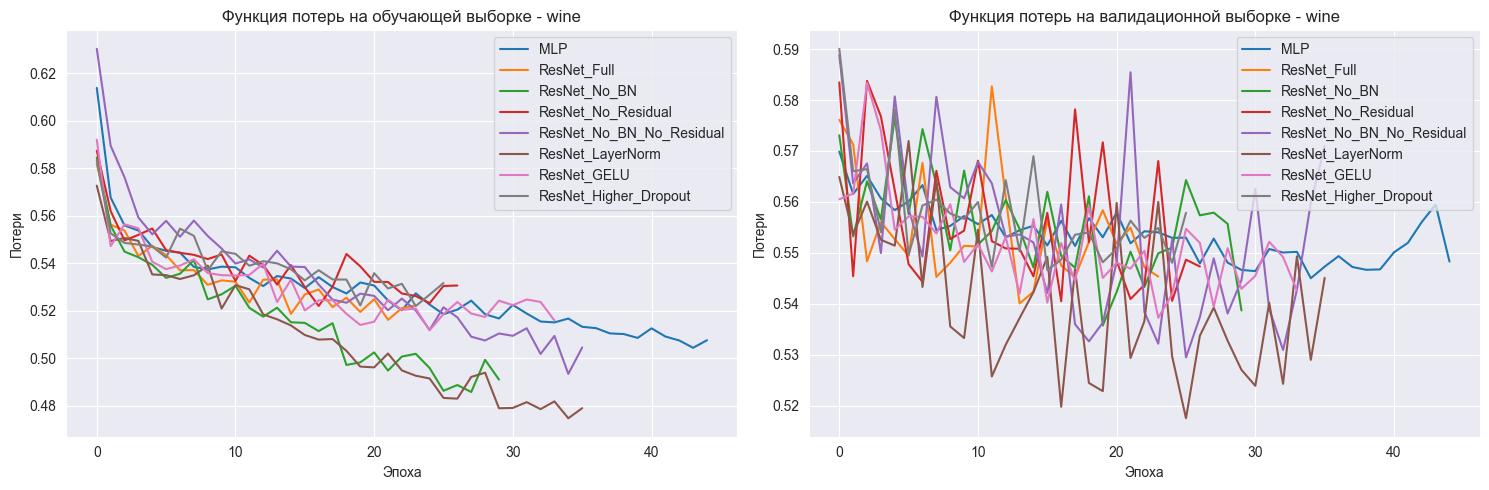

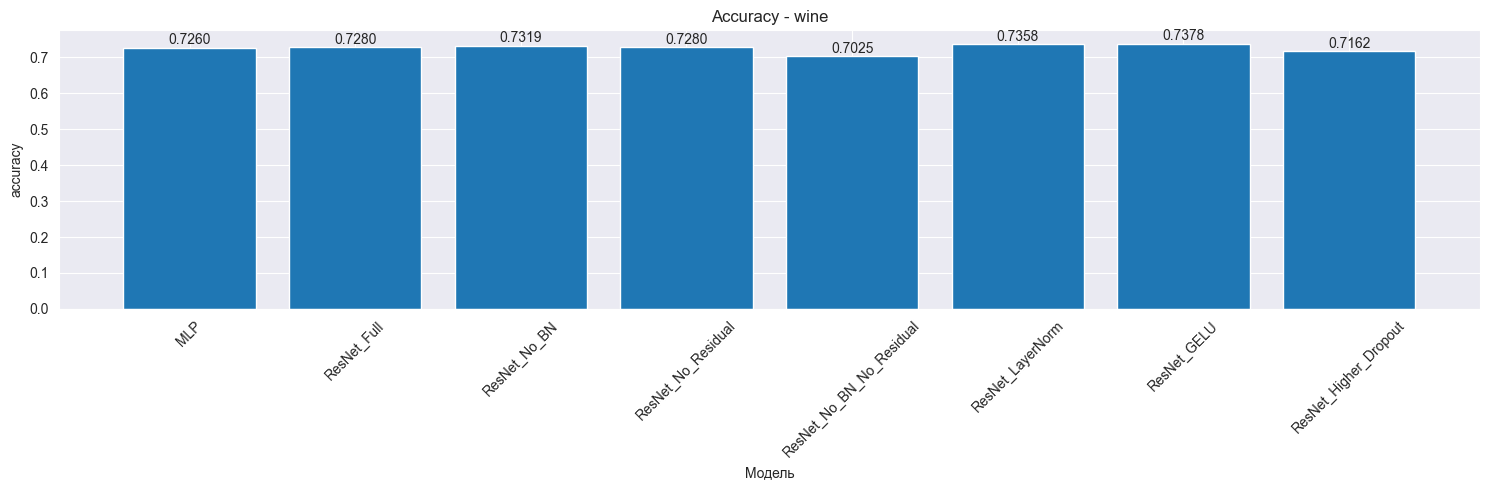


=== Обработка датасета: houses ===
Датасет houses загружен

Training MLP...
Эпоха 10/100, Потери на обучении: 10305823626.0101, Потери на валидации: 10049863799.0698
Эпоха 20/100, Потери на обучении: 6339076228.3316, Потери на валидации: 6286809413.4574
Эпоха 30/100, Потери на обучении: 4953248032.6953, Потери на валидации: 4983882156.6512
Эпоха 40/100, Потери на обучении: 4585279059.9185, Потери на валидации: 4639197277.2713
Эпоха 50/100, Потери на обучении: 4520897429.0572, Потери на валидации: 4546550853.4574
Эпоха 60/100, Потери на обучении: 4431923648.0048, Потери на валидации: 4486654805.3333
Эпоха 70/100, Потери на обучении: 4405362258.4262, Потери на валидации: 4446769745.3643
Эпоха 80/100, Потери на обучении: 4393065735.8880, Потери на валидации: 4419547749.2093
Эпоха 90/100, Потери на обучении: 4310900389.8990, Потери на валидации: 4398815158.5736
Эпоха 100/100, Потери на обучении: 4274527809.8945, Потери на валидации: 4373379000.5581
Results for MLP:
  mse: 4373379072.0000


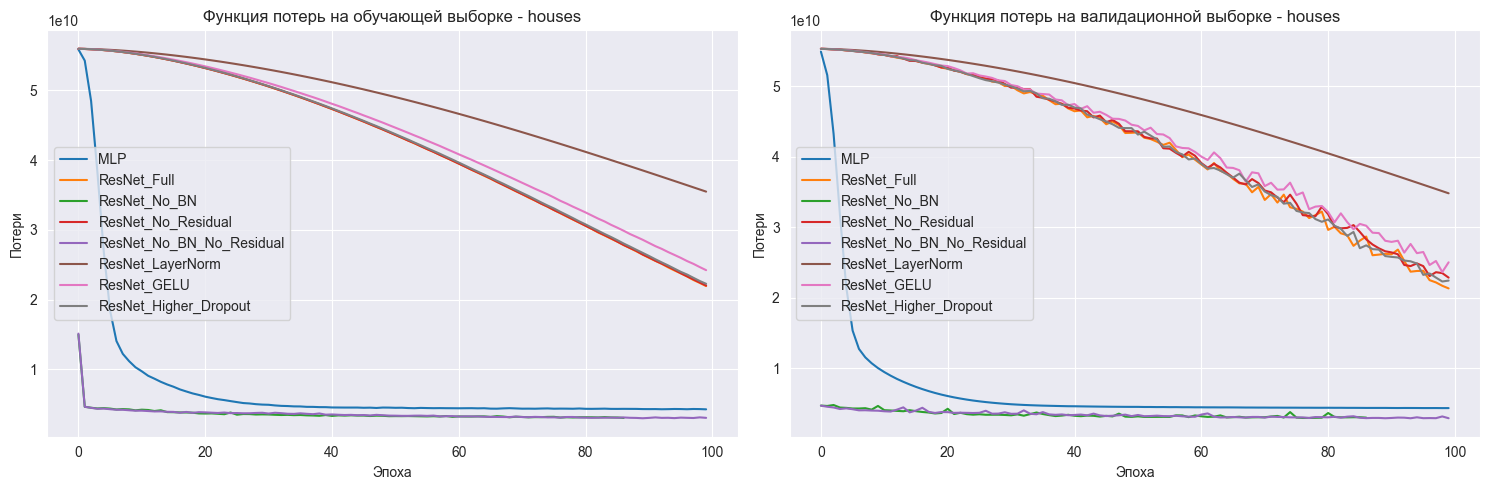

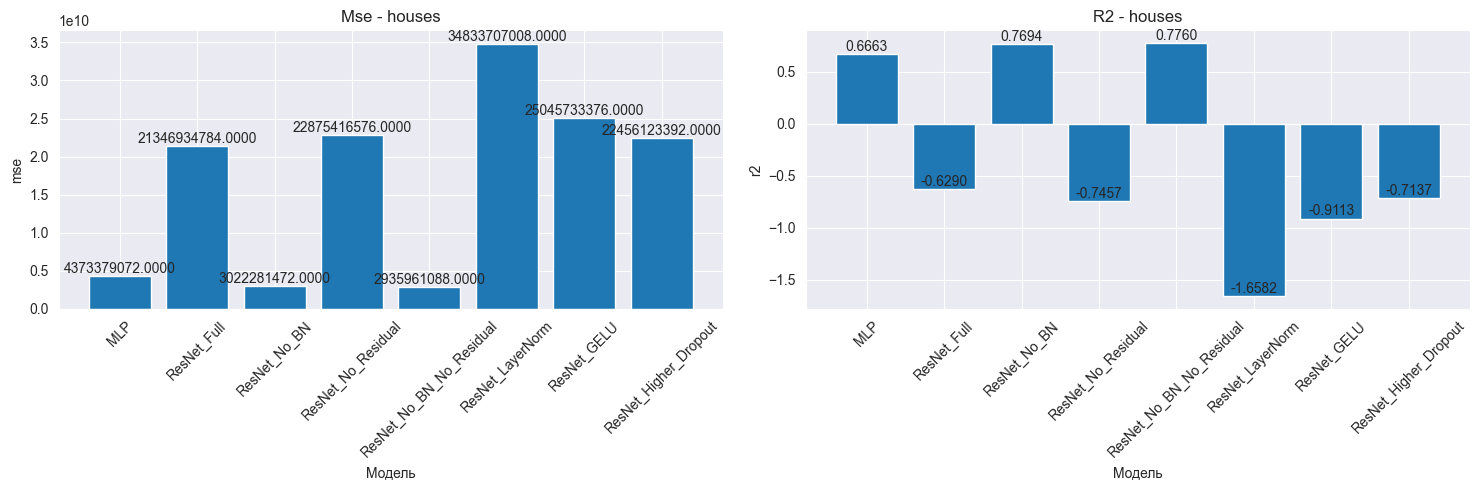


=== Обработка датасета: Pumpkin_Seeds ===
Датасет Pumpkin_Seeds загружен

Training MLP...
Эпоха 10/100, Потери на обучении: 0.2664, Потери на валидации: 0.3199
Эпоха 20/100, Потери на обучении: 0.2546, Потери на валидации: 0.3174
Ранняя остановка на эпохе 22
Results for MLP:
  accuracy: 0.8660

Training ResNet_Full...
Эпоха 10/100, Потери на обучении: 0.2795, Потери на валидации: 0.3262
Эпоха 20/100, Потери на обучении: 0.2587, Потери на валидации: 0.3246
Ранняя остановка на эпохе 21
Results for ResNet_Full:
  accuracy: 0.8660

Training ResNet_No_BN...
Эпоха 10/100, Потери на обучении: 0.2684, Потери на валидации: 0.3261
Эпоха 20/100, Потери на обучении: 0.2422, Потери на валидации: 0.3273
Ранняя остановка на эпохе 22
Results for ResNet_No_BN:
  accuracy: 0.8760

Training ResNet_No_Residual...
Эпоха 10/100, Потери на обучении: 0.2769, Потери на валидации: 0.3407
Ранняя остановка на эпохе 15
Results for ResNet_No_Residual:
  accuracy: 0.8660

Training ResNet_No_BN_No_Residual...
Эпоха 

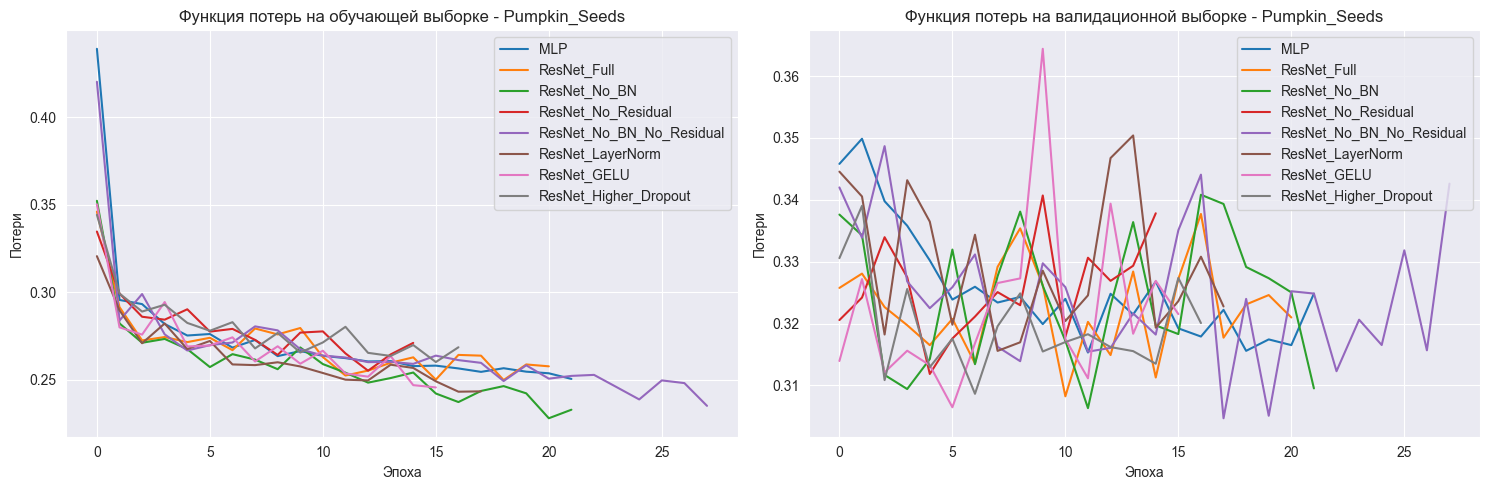

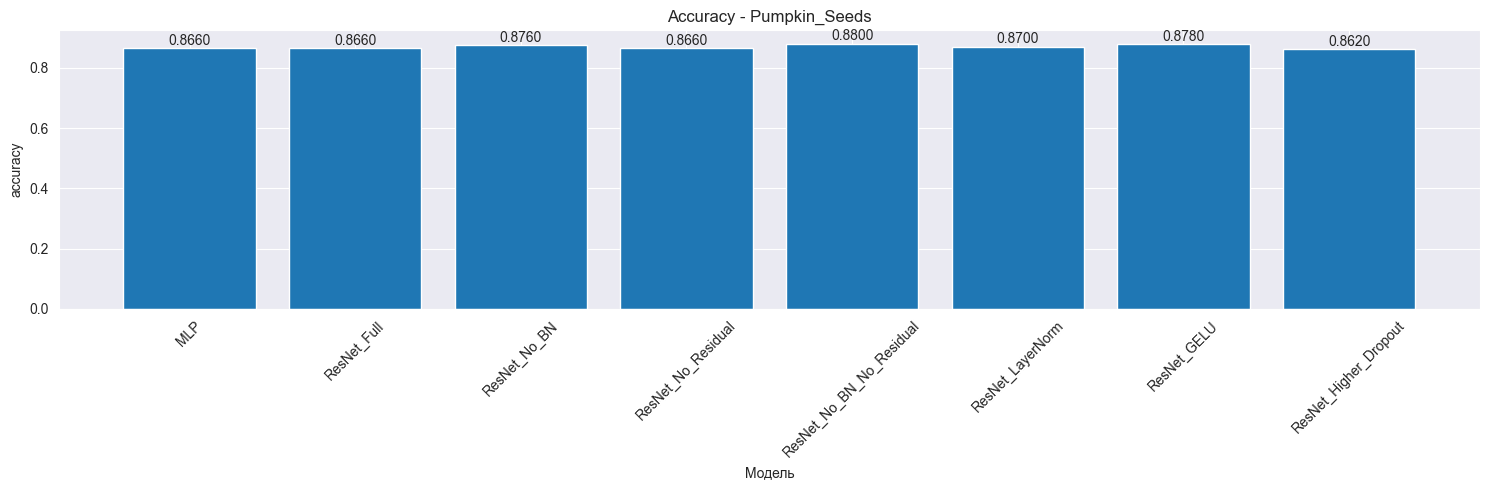

Используем accuracy как основную метрику для wine
Используем mse как основную метрику для houses
Используем accuracy как основную метрику для Pumpkin_Seeds

=== Анализ важности компонентов ===
Влияние BatchNorm: -1.4023
Влияние остаточных соединений: 0.1165
Влияние LayerNorm вместо BatchNorm: -1.0228
Влияние GELU вместо ReLU: -0.2728
Влияние повышенного Dropout: -0.0915


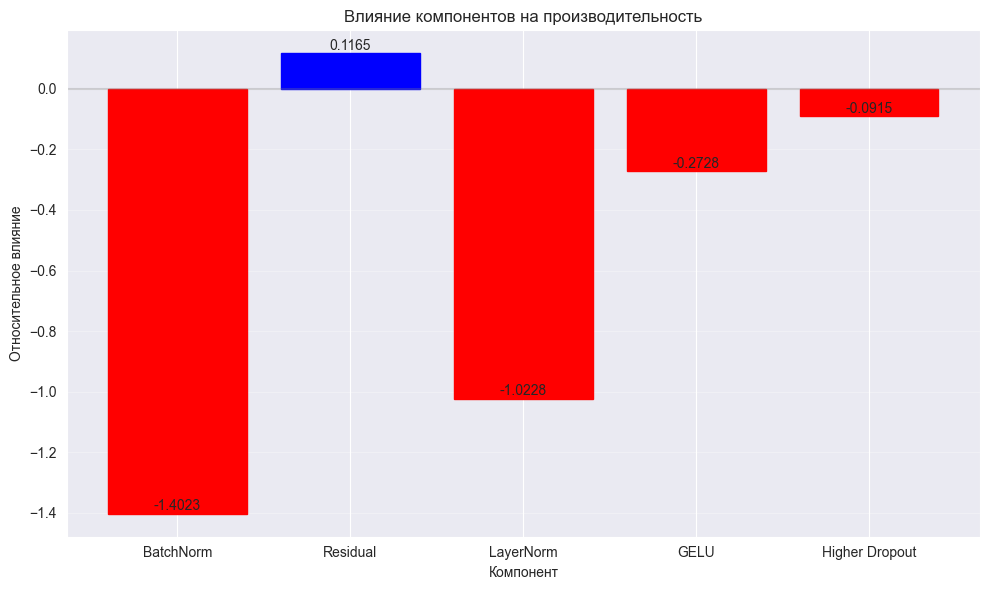

In [123]:
# Запускаем эксперименты для каждого датасета
all_results = {}

for dataset_name in datasets:
    print(f"\n=== Обработка датасета: {dataset_name} ===")

    # Проверяем наличие датасета
    if not check_dataset(dataset_name):
        print(f"Датасет {dataset_name} не найден, пропускаем.")
        continue

    # Загружаем датасет
    dataset_data = load_dataset(dataset_name)

    # Предобрабатываем данные
    dataset_info = preprocess_data(dataset_data)

    # Запускаем эксперименты
    results = run_experiments(
        dataset_info=dataset_info,
        model_configs=model_configs,
        device=device
    )

    # Визуализируем результаты
    plot_results(results, dataset_info['task_type'], dataset_name)

    # Сохраняем результаты
    all_results[dataset_name] = {
        'task_type': dataset_info['task_type'],
        'results': results
    }

# Анализируем важность компонентов
analysis_results = analyze_component_importance(all_results)

# Выводим результаты анализа важности компонентов
print("\n=== Анализ важности компонентов ===")
print(f"Влияние BatchNorm: {analysis_results['bn_impact']:.4f}")
print(f"Влияние остаточных соединений: {analysis_results['residual_impact']:.4f}")

if analysis_results['layernorm_impact'] is not None:
    print(f"Влияние LayerNorm вместо BatchNorm: {analysis_results['layernorm_impact']:.4f}")

if analysis_results['gelu_impact'] is not None:
    print(f"Влияние GELU вместо ReLU: {analysis_results['gelu_impact']:.4f}")

if analysis_results['dropout_impact'] is not None:
    print(f"Влияние повышенного Dropout: {analysis_results['dropout_impact']:.4f}")

# Визуализируем
importance_data = [
    ('BatchNorm', analysis_results['bn_impact']),
    ('Residual', analysis_results['residual_impact'])
]

if analysis_results['layernorm_impact'] is not None:
    importance_data.append(('LayerNorm', analysis_results['layernorm_impact']))
if analysis_results['gelu_impact'] is not None:
    importance_data.append(('GELU', analysis_results['gelu_impact']))
if analysis_results['dropout_impact'] is not None:
    importance_data.append(('Higher Dropout', analysis_results['dropout_impact']))

components, impacts = zip(*importance_data)

plt.figure(figsize=(10, 6))
bars = plt.bar(components, impacts)

for bar, impact in zip(bars, impacts):
    if impact > 0:
        bar.set_color('blue')  # Положительное влияние
    else:
        bar.set_color('red')   # Отрицательное влияние

plt.axhline(y=0, color='gray', linestyle='-', alpha=0.3)
plt.title('Влияние компонентов на производительность')
plt.xlabel('Компонент')
plt.ylabel('Относительное влияние')
plt.grid(axis='y', alpha=0.3)

for bar in bars:
    height = bar.get_height()
    plt.text(bar.get_x() + bar.get_width()/2., height + 0.001,
            f'{height:.4f}', ha='center', va='bottom', rotation=0)

plt.tight_layout()
plt.savefig('component_importance.png')
plt.show()

# Сделаем выводы:
1. На всех трех датасетах удаление BatchNorm приводило к улучшению результатов.
2. residual connection показывает смешанные результаты:
   - На датасете wine улучшается результат
   - На датасетах houses и Pumpkin_Seeds наоборот
3. LayerNorm
   - Работает хорошо на датасетах wine и Pumpkin_Seeds
   - Показывает худший результат на датасете houses
4. GELU как альтернатива ReLU:
   - Эффективен на датасетах wine и Pumpkin_Seeds
   - Очень неэффективен на датасете houses
5. Увеличение уровня Dropout не приносит пользы ни на одном из датасетов.

# Итого
1. Удаление BatchNorm является наиболее стабильной модификацией, которая улучшает результаты на всех трех датасетах.
2. Для некоторых задач модель без BatchNorm и без residual connection может дать наилучший результат (как на houses и Pumpkin_Seeds).
3. Выбор активации (ReLU, GELU) сильно зависит от датасета и требует экспериментальной проверки.
4. MLP может быть конкурентоспособной или даже превосходить ResNet на некоторых табличных датасетах.

# Дополнительно

In [124]:
import copy
from typing import List

In [125]:
# для преобразования признаков в embeddings
class FeatureTokenizer(nn.Module):
    def __init__(self, num_continuous, cat_cardinalities=None, embedding_dim=32):
        super().__init__()
        self.num_continuous = num_continuous
        self.cat_cardinalities = cat_cardinalities or []

        # Отдельный embedding для каждого числового признака
        self.num_embeddings = nn.ModuleList([
            nn.Sequential(
                nn.Linear(1, embedding_dim),
                nn.LayerNorm(embedding_dim),
                nn.GELU(),
                nn.Linear(embedding_dim, embedding_dim),
            ) for _ in range(num_continuous)
        ])

        # Embedding для категориальных признаков
        self.cat_embeddings = nn.ModuleList([
            nn.Embedding(cardinality, embedding_dim)
            for cardinality in self.cat_cardinalities
        ])

    def forward(self, x_num, x_cat=None):
        # Обработка числовых признаков
        num_embeddings = []
        for i, embedding_layer in enumerate(self.num_embeddings):
            feat = x_num[:, i:i+1]
            num_embeddings.append(embedding_layer(feat))

        # Обработка категориальных признаков
        cat_embeddings = []
        if x_cat is not None and len(self.cat_embeddings) > 0:
            for i, embedding_layer in enumerate(self.cat_embeddings):
                cat_embeddings.append(embedding_layer(x_cat[:, i]))

        # Объединяем все embeddings
        all_embeddings = torch.cat(num_embeddings + cat_embeddings, dim=1)
        return all_embeddings

In [126]:
# Улучшенный ResNet блок с GLU и pre-LayerNorm
class ImprovedResBlock(nn.Module):
    def __init__(self, d, activation='gelu', use_layer_norm=True, dropout=0.1, use_glu=True):
        super().__init__()

        # Pre-norm архитектура
        self.norm1 = nn.LayerNorm(d) if use_layer_norm else nn.Identity()

        # GLU требует двойной размерности
        self.use_glu = use_glu
        d_hidden = d * 2 if use_glu else d

        # Линейные слои
        self.linear1 = nn.Linear(d, d_hidden)
        self.linear2 = nn.Linear(d // 2 if use_glu else d, d)

        # Dropout
        self.dropout = nn.Dropout(dropout)

        # Активация
        self.activation = nn.GELU() if activation == 'gelu' else nn.ReLU()

    def forward(self, x):
        # Сохраняем для остаточного соединения
        residual = x

        # Pre-norm
        z = self.norm1(x)

        # Первый линейный слой
        z = self.linear1(z)

        # GLU активация или обычная
        if self.use_glu:
            # Разделяем на два тензора и применяем GLU
            a, b = z.chunk(2, dim=-1)
            z = a * self.activation(b)
        else:
            z = self.activation(z)

        # Dropout
        z = self.dropout(z)

        # Второй линейный слой
        z = self.linear2(z)

        # Остаточное соединение
        return residual + z

In [127]:
# Упрощенный механизм взаимодействия признаков вместо сложного внимания
class FeatureInteraction(nn.Module):
    def __init__(self, hidden_dim, dropout=0.1):
        super().__init__()
        self.hidden_dim = hidden_dim

        # Используем два полносвязных слоя с нелинейностью вместо внимания
        self.interaction = nn.Sequential(
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim),
            nn.GELU(),
            nn.Dropout(dropout),
            nn.Linear(hidden_dim, hidden_dim),
            nn.LayerNorm(hidden_dim)
        )

    def forward(self, x):
        # Применяем взаимодействие признаков через остаточное соединение
        return x + self.interaction(x)

In [128]:
class TabResFormer(nn.Module):
    def __init__(
        self,
        *,
        num_continuous: int,
        cat_cardinalities: List[int] = None,
        embedding_dim: int = 32,
        hidden_dim: int = 128,
        n_layers: int = 3,
        dropout: float = 0.1,
        use_layer_norm: bool = True,
        activation: str = 'gelu',
        use_glu: bool = True,
        d_out: int = 1,
        pretrain_mode: str = None,  # 'vime' или 'scarf'
    ):
        super().__init__()

        # Сохраняем параметры
        self.num_continuous = num_continuous
        self.cat_cardinalities = cat_cardinalities or []
        self.d_out = d_out
        self.pretrain_mode = pretrain_mode

        self.num_embeddings = nn.Linear(num_continuous, embedding_dim)

        # Слой объединения признаков
        self.feature_combiner = nn.Sequential(
            nn.Linear(embedding_dim, hidden_dim),
            nn.LayerNorm(hidden_dim) if use_layer_norm else nn.Identity(),
            nn.GELU() if activation == 'gelu' else nn.ReLU(),
        )

        self.res_blocks = nn.ModuleList()
        for _ in range(n_layers):
            block = nn.ModuleDict({
                'norm': nn.LayerNorm(hidden_dim) if use_layer_norm else nn.Identity(),
                'linear1': nn.Linear(hidden_dim, hidden_dim * 2 if use_glu else hidden_dim),
                'linear2': nn.Linear(hidden_dim if use_glu else hidden_dim, hidden_dim)
            })
            self.res_blocks.append(block)

        self.use_glu = use_glu
        self.activation = nn.GELU() if activation == 'gelu' else nn.ReLU()
        self.dropout = nn.Dropout(dropout)

        self.head = nn.Linear(hidden_dim, d_out)

        # Настройка предобучения
        if pretrain_mode == 'vime':
            self.value_imputer = nn.Linear(hidden_dim, num_continuous)
            self.mask_estimator = nn.Linear(hidden_dim, num_continuous)
        elif pretrain_mode == 'scarf':
            self.projection_head = nn.Sequential(
                nn.Linear(hidden_dim, hidden_dim),
                nn.ReLU(),
                nn.Linear(hidden_dim, 128)
            )

    def get_features(self, x_num, x_cat=None):  # для предобучения
        # Простое преобразование признаков
        x = self.num_embeddings(x_num)

        # Объединение признаков
        x = self.feature_combiner(x)

        # Применяем ResNet блоки
        for block in self.res_blocks:
            # Сохраняем для остаточного соединения
            residual = x

            # Применяем нормализацию
            z = block['norm'](x)

            # Первый линейный слой
            z = block['linear1'](z)

            # GLU активация или обычная
            if self.use_glu:
                # Разделяем на два тензора и применяем GLU
                a, b = z.chunk(2, dim=-1)
                z = a * self.activation(b)
            else:
                z = self.activation(z)

            # Dropout
            z = self.dropout(z)

            # Второй линейный слой
            z = block['linear2'](z)

            # Остаточное соединение
            x = residual + z

        return x

    def forward(self, x_num, x_cat=None):
        # Получаем признаки через метод get_features
        x = self.get_features(x_num, x_cat)

        outputs = self.head(x)

        # Убираем лишнюю размерность для задач бинарной классификации и регрессии
        if self.d_out == 1:
            outputs = outputs.squeeze(-1)

        return outputs

In [129]:
# Функции для предобучения - VIME
def vime_pretrain_step(model, x_num, x_cat=None, mask_prob=0.2):
    # Проверяем, что модель настроена на VIME
    assert model.pretrain_mode == 'vime', "Модель должна быть настроена с pretrain_mode='vime'"

    # Создаем маску для случайного маскирования признаков
    mask = torch.bernoulli(torch.full(x_num.shape, mask_prob)).bool().to(x_num.device)

    original_x_num = x_num.clone()

    # Заменяем замаскированные значения на случайные
    x_num_corrupted = x_num.clone()
    random_values = torch.randn_like(x_num)
    x_num_corrupted[mask] = random_values[mask]

    # Получаем embeddings и признаки
    features = model.get_features(x_num_corrupted, x_cat)

    # Предсказываем оригинальные значения
    imputed_values = model.value_imputer(features)

    # Предсказываем маску
    mask_logits = model.mask_estimator(features)

    # Вычисляем потери
    value_loss = F.mse_loss(imputed_values[mask], original_x_num[mask])
    mask_loss = F.binary_cross_entropy_with_logits(mask_logits, mask.float())

    return value_loss + mask_loss

In [130]:
# Функции для предобучения - SCARF
def scarf_pretrain_step(model, x_num, x_cat=None, temperature=0.1):
    # Проверяем, что модель настроена на SCARF
    assert model.pretrain_mode == 'scarf', "Модель должна быть настроена с pretrain_mode='scarf'"

    batch_size = x_num.size(0)
    device = x_num.device

    # Создаем две случайные аугментации данных
    def augment(x):
        # Простая аугментация: добавляем шум
        noise = torch.randn_like(x) * 0.1
        return x + noise

    x_num_aug1 = augment(x_num)
    x_num_aug2 = augment(x_num)

    # Получаем представления для обеих аугментаций
    features1 = model.get_features(x_num_aug1, x_cat)
    features2 = model.get_features(x_num_aug2, x_cat)

    z1 = model.projection_head(features1)
    z2 = model.projection_head(features2)

    # Нормализация
    z1 = F.normalize(z1, dim=1)
    z2 = F.normalize(z2, dim=1)

    # Объединяем представления для вычисления потерь
    representations = torch.cat([z1, z2], dim=0)

    # Вычисляем матрицу сходства
    similarity_matrix = torch.matmul(representations, representations.T)

    # Маска для позитивных пар
    mask = torch.zeros((2 * batch_size, 2 * batch_size), dtype=torch.bool, device=device)
    mask[:batch_size, batch_size:] = torch.eye(batch_size, device=device)
    mask[batch_size:, :batch_size] = torch.eye(batch_size, device=device)

    # Вычисляем потери
    positives = similarity_matrix[mask].view(2 * batch_size, 1)
    negatives = similarity_matrix[~mask].view(2 * batch_size, -1)

    logits = torch.cat([positives, negatives], dim=1) / temperature
    labels = torch.zeros(2 * batch_size, dtype=torch.long, device=device)

    loss = F.cross_entropy(logits, labels)

    return loss

In [131]:
def create_tabresformer_model_configs():  # создает конфигурации
    base_config = {
        'model_type': 'tabresformer',
        'num_continuous': None,  # Будет задано динамически
        'embedding_dim': 32,
        'hidden_dim': 128,
        'n_layers': 3,
        'dropout': 0.1,
        'use_layer_norm': True,
        'activation': 'gelu',
        'use_glu': True,
    }

    tabresformer_configs = {
        'TabResFormer_Base': {**base_config},

        'TabResFormer_NoGLU': {
            **base_config,
            'use_glu': False
        },

        'TabResFormer_VIME': {
            **base_config,
            'pretrain_mode': 'vime'
        },

        'TabResFormer_SCARF': {
            **base_config,
            'pretrain_mode': 'scarf'
        },

        'TabResFormer_ReLU': {
            **base_config,
            'activation': 'relu'
        }
    }

    return tabresformer_configs

In [132]:
def create_model(config, num_features, num_classes, device):
    if config['model_type'] == 'mlp':
        model = MLP(
            d_in=num_features,
            d_out=num_classes if num_classes > 1 else 1,
            d_layers=config['d_layers'],
            dropout=config['dropout']
        )
    elif config['model_type'] == 'resnet':
        model = ResNet(
            d_in=num_features,
            d=config['d'],
            d_hidden_factor=config['d_hidden_factor'],
            n_layers=config['n_layers'],
            activation=config['activation'],
            normalization=config['normalization'],
            hidden_dropout=config['hidden_dropout'],
            residual_dropout=config['residual_dropout'],
            d_out=num_classes if num_classes > 1 else 1,
            use_normalization=config.get('use_normalization', True),
            use_residual=config.get('use_residual', True)
        )
    elif config['model_type'] == 'tabresformer':
        # Удаляем n_heads из параметров, если он присутствует в config
        tabresformer_params = {
            'num_continuous': num_features,
            'cat_cardinalities': None,
            'embedding_dim': config['embedding_dim'],
            'hidden_dim': config['hidden_dim'],
            'n_layers': config['n_layers'],
            'dropout': config['dropout'],
            'use_layer_norm': config['use_layer_norm'],
            'activation': config['activation'],
            'use_glu': config.get('use_glu', True),
            'd_out': num_classes if num_classes > 1 else 1,
            'pretrain_mode': config.get('pretrain_mode', None)
        }

        model = TabResFormer(**tabresformer_params)
    else:
        raise ValueError(f"Неизвестный тип модели: {config['model_type']}")

    return model.to(device)

In [133]:
# Функция для выполнения предобучения модели
def pretrain_model(model, train_loader, val_loader, device, epochs=10, lr=0.001):
    if not hasattr(model, 'pretrain_mode') or model.pretrain_mode is None:
        raise ValueError("Модель должна быть в режиме предобучения (VIME или SCARF)")

    # Создаем оптимизатор
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # История обучения
    train_losses = []
    val_losses = []

    # Обучение
    for epoch in range(epochs):
        # Режим обучения
        model.train()
        epoch_train_loss = 0.0

        for inputs, _ in train_loader:  # Игнорируем метки в предобучении
            inputs = inputs.to(device)

            # Обнуляем градиенты
            optimizer.zero_grad()

            # Вычисляем потери в зависимости от режима предобучения
            if model.pretrain_mode == 'vime':
                loss = vime_pretrain_step(model, inputs)
            else:  # scarf
                loss = scarf_pretrain_step(model, inputs)

            # Обратное распространение ошибки
            loss.backward()
            optimizer.step()

            epoch_train_loss += loss.item() * inputs.size(0)

        # Вычисляем среднюю потерю на эпохе
        epoch_train_loss /= len(train_loader.dataset)
        train_losses.append(epoch_train_loss)

        # Режим оценки
        model.eval()
        epoch_val_loss = 0.0

        with torch.no_grad():
            for inputs, _ in val_loader:
                inputs = inputs.to(device)

                # Вычисляем потери на валидационных данных
                if model.pretrain_mode == 'vime':
                    loss = vime_pretrain_step(model, inputs)
                else:  # scarf
                    loss = scarf_pretrain_step(model, inputs)

                epoch_val_loss += loss.item() * inputs.size(0)

        # Вычисляем среднюю потерю на валидации
        epoch_val_loss /= len(val_loader.dataset)
        val_losses.append(epoch_val_loss)

        # Выводим информацию
        print(f"Эпоха {epoch+1}/{epochs}, Потери на обучении: {epoch_train_loss:.4f}, "
              f"Потери на валидации: {epoch_val_loss:.4f}")

    return model, {'train_losses': train_losses, 'val_losses': val_losses}

In [134]:
# Функция для настройки предобученной модели
def finetune_model(pretrained_model, train_loader, val_loader, criterion, task_type, device,
                 epochs=50, lr=0.0005, patience=10):
    # Копируем модель
    model = copy.deepcopy(pretrained_model)

    # Создаем оптимизатор с меньшей скоростью обучения
    optimizer = torch.optim.Adam(model.parameters(), lr=lr)

    # Обучаем модель с ранней остановкой
    return train_model(
        model=model,
        train_loader=train_loader,
        test_loader=val_loader,
        criterion=criterion,
        optimizer=optimizer,
        device=device,
        task_type=task_type,
        epochs=epochs,
        patience=patience,
        verbose=True
    )

In [135]:
def run_tabresformer_experiments(dataset_info, model_configs, device,
                               do_pretrain=True, pretrain_epochs=10,
                               batch_size=64, lr=0.001):
    # Извлекаем данные
    train_dataset = dataset_info['train_dataset']
    val_dataset = dataset_info['val_dataset']
    test_dataset = dataset_info['test_dataset']
    num_features = dataset_info['num_features']
    num_classes = dataset_info['num_classes']
    task_type = dataset_info['task_type']

    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)
    test_loader = DataLoader(test_dataset, batch_size=batch_size)

    # Определяем функцию потерь
    if task_type == 'classification':
        if num_classes > 1:
            criterion = nn.CrossEntropyLoss()
        else:
            criterion = nn.BCEWithLogitsLoss()
    else:
        criterion = nn.MSELoss()

    results = {}

    # Обучаем и оцениваем каждую конфигурацию модели
    for name, config in model_configs.items():
        print(f"\nОбучение {name}...")

        # Создаем модель
        model = create_model(config, num_features, num_classes, device)

        if do_pretrain and hasattr(model, 'pretrain_mode') and model.pretrain_mode is not None:
            print(f"Предобучение модели {name} в режиме {model.pretrain_mode}...")
            model, pretrain_results = pretrain_model(
                model=model,
                train_loader=train_loader,
                val_loader=val_loader,
                device=device,
                epochs=pretrain_epochs,
                lr=lr
            )

        # Создаем оптимизатор
        optimizer = torch.optim.Adam(model.parameters(), lr=lr)

        # Обучаем модель с ранней остановкой
        train_results = train_model(
            model=model,
            train_loader=train_loader,
            test_loader=val_loader,
            criterion=criterion,
            optimizer=optimizer,
            device=device,
            task_type=task_type,
            verbose=True
        )

        # Оцениваем модель на тестовой выборке
        eval_metrics = evaluate_model(
            model=train_results['model'],
            test_loader=test_loader,
            task_type=task_type,
            device=device
        )

        # Сохраняем результаты
        results[name] = {
            'train_losses': train_results['train_losses'],
            'test_losses': train_results['test_losses'],
            'metrics': eval_metrics
        }

        # Выводим метрики на тестовой выборке
        print(f"Результаты на тестовой выборке для {name}:")
        for metric_name, metric_value in eval_metrics.items():
            print(f"  {metric_name}: {metric_value:.4f}")

    return results


=== Обработка датасета: wine ===
Датасет wine загружен

Обучение TabResFormer_Base...
Эпоха 10/100, Потери на обучении: 0.5189, Потери на валидации: 0.5134
Ранняя остановка на эпохе 15
Результаты на тестовой выборке для TabResFormer_Base:
  accuracy: 0.7299

Обучение TabResFormer_NoGLU...
Эпоха 10/100, Потери на обучении: 0.5332, Потери на валидации: 0.5062
Эпоха 20/100, Потери на обучении: 0.5109, Потери на валидации: 0.5055
Ранняя остановка на эпохе 29
Результаты на тестовой выборке для TabResFormer_NoGLU:
  accuracy: 0.7182

Обучение TabResFormer_VIME...
Предобучение модели TabResFormer_VIME в режиме vime...
Эпоха 1/5, Потери на обучении: 1.4122, Потери на валидации: 1.5341
Эпоха 2/5, Потери на обучении: 1.3421, Потери на валидации: 1.3409
Эпоха 3/5, Потери на обучении: 1.3607, Потери на валидации: 1.4203
Эпоха 4/5, Потери на обучении: 1.3120, Потери на валидации: 1.2570
Эпоха 5/5, Потери на обучении: 1.2607, Потери на валидации: 1.2489
Эпоха 10/100, Потери на обучении: 0.5235, Пот

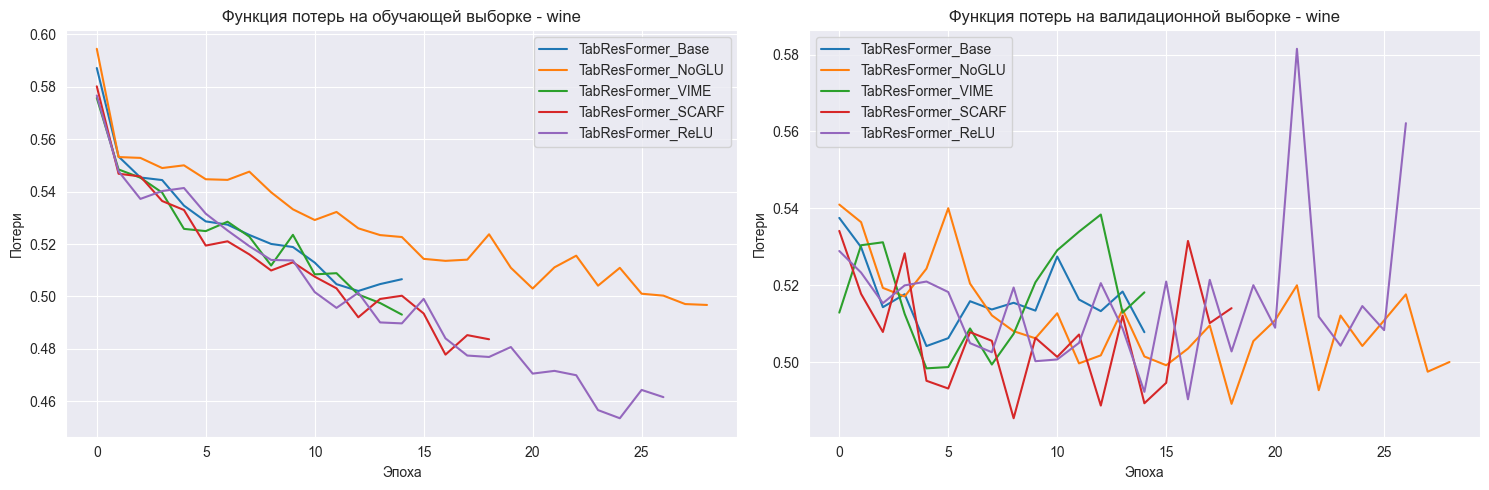

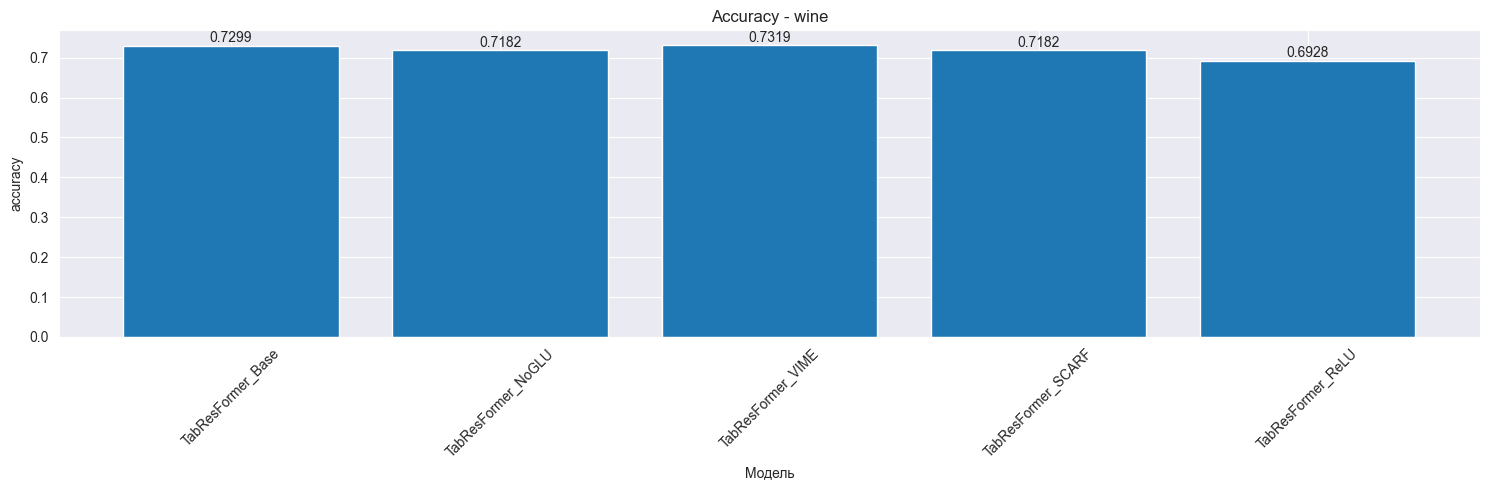


=== Обработка датасета: houses ===
Датасет houses загружен

Обучение TabResFormer_Base...
Эпоха 10/100, Потери на обучении: 3107869788.3492, Потери на валидации: 3325317474.5092
Эпоха 20/100, Потери на обучении: 2866940114.1646, Потери на валидации: 3076669315.3715
Эпоха 30/100, Потери на обучении: 2674219155.8556, Потери на валидации: 2925853985.4048
Эпоха 40/100, Потери на обучении: 2622778432.0630, Потери на валидации: 2955962653.2195
Эпоха 50/100, Потери на обучении: 2454009851.3292, Потери на валидации: 2817357320.9131
Эпоха 60/100, Потери на обучении: 2390787050.2839, Потери на валидации: 2840763582.9731
Эпоха 70/100, Потери на обучении: 2241997006.5210, Потери на валидации: 2997102707.4054
Ранняя остановка на эпохе 72
Результаты на тестовой выборке для TabResFormer_Base:
  mse: 2715752960.0000
  r2: 0.7928

Обучение TabResFormer_NoGLU...
Эпоха 10/100, Потери на обучении: 3977921484.8736, Потери на валидации: 4246673091.2358
Эпоха 20/100, Потери на обучении: 3383150110.6991, Пот

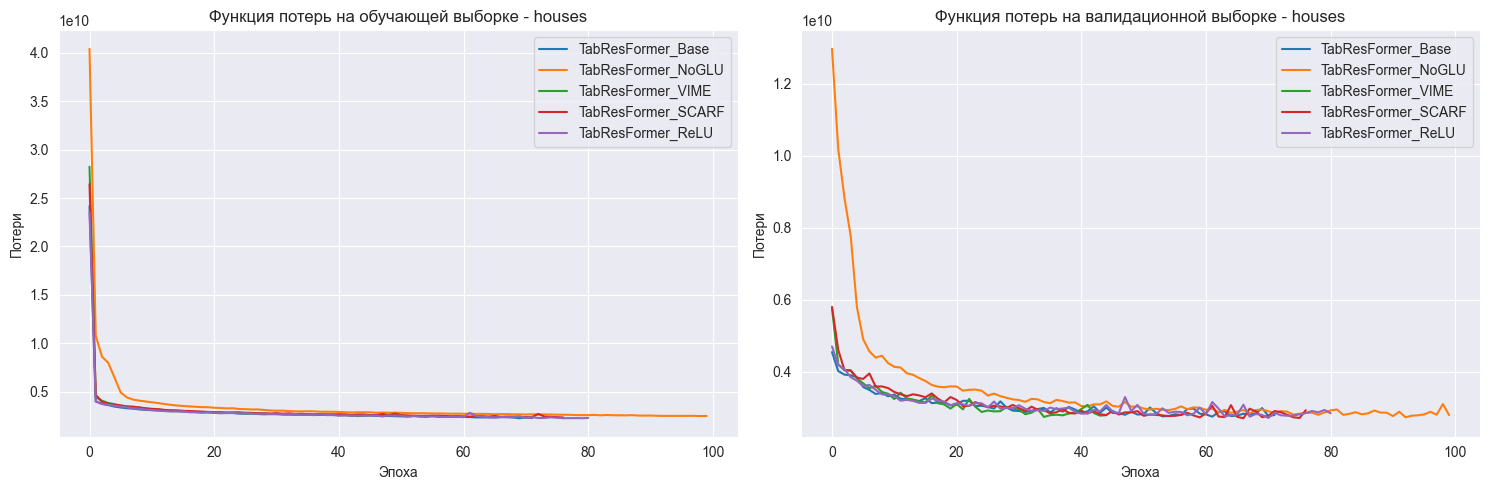

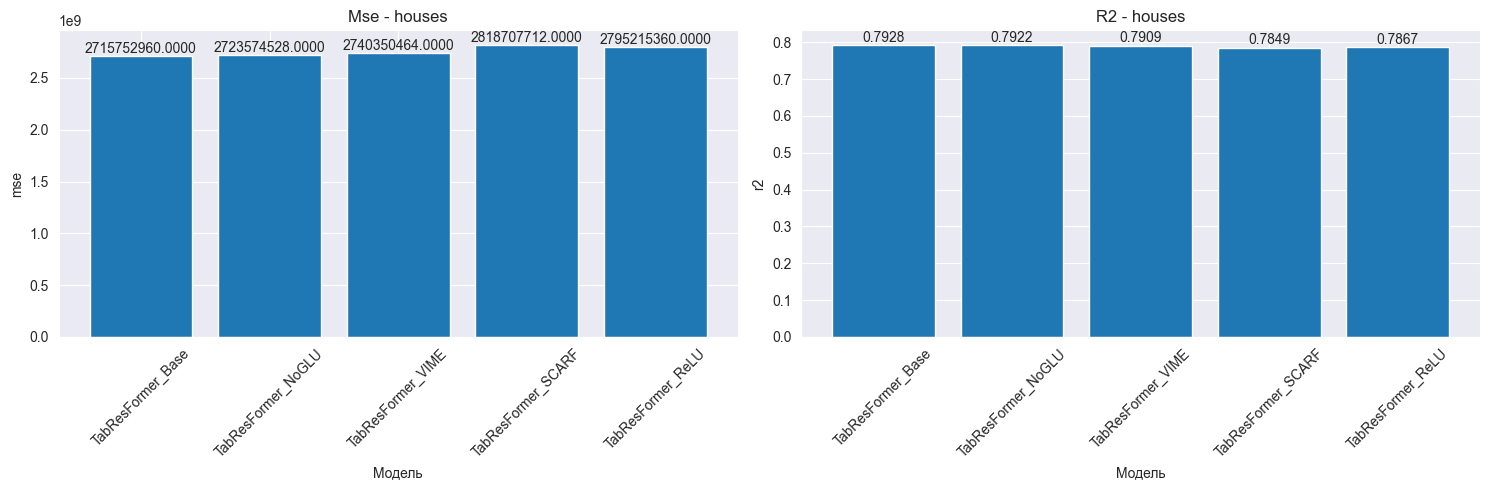


=== Обработка датасета: Pumpkin_Seeds ===
Датасет Pumpkin_Seeds загружен

Обучение TabResFormer_Base...
Эпоха 10/100, Потери на обучении: 0.2451, Потери на валидации: 0.3248
Ранняя остановка на эпохе 14
Результаты на тестовой выборке для TabResFormer_Base:
  accuracy: 0.8640

Обучение TabResFormer_NoGLU...
Эпоха 10/100, Потери на обучении: 0.2536, Потери на валидации: 0.3252
Эпоха 20/100, Потери на обучении: 0.2344, Потери на валидации: 0.3808
Ранняя остановка на эпохе 21
Результаты на тестовой выборке для TabResFormer_NoGLU:
  accuracy: 0.8820

Обучение TabResFormer_VIME...
Предобучение модели TabResFormer_VIME в режиме vime...
Эпоха 1/5, Потери на обучении: 1.1566, Потери на валидации: 0.8822
Эпоха 2/5, Потери на обучении: 0.8605, Потери на валидации: 0.7744
Эпоха 3/5, Потери на обучении: 0.7951, Потери на валидации: 0.7669
Эпоха 4/5, Потери на обучении: 0.7771, Потери на валидации: 0.8060
Эпоха 5/5, Потери на обучении: 0.7465, Потери на валидации: 0.7355
Эпоха 10/100, Потери на обу

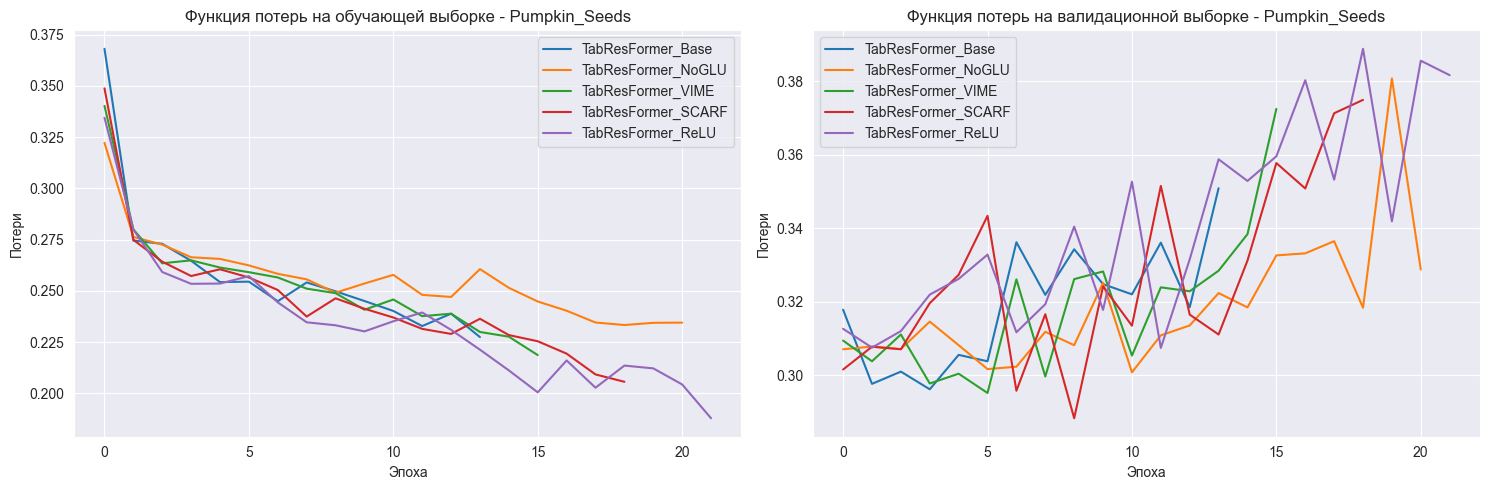

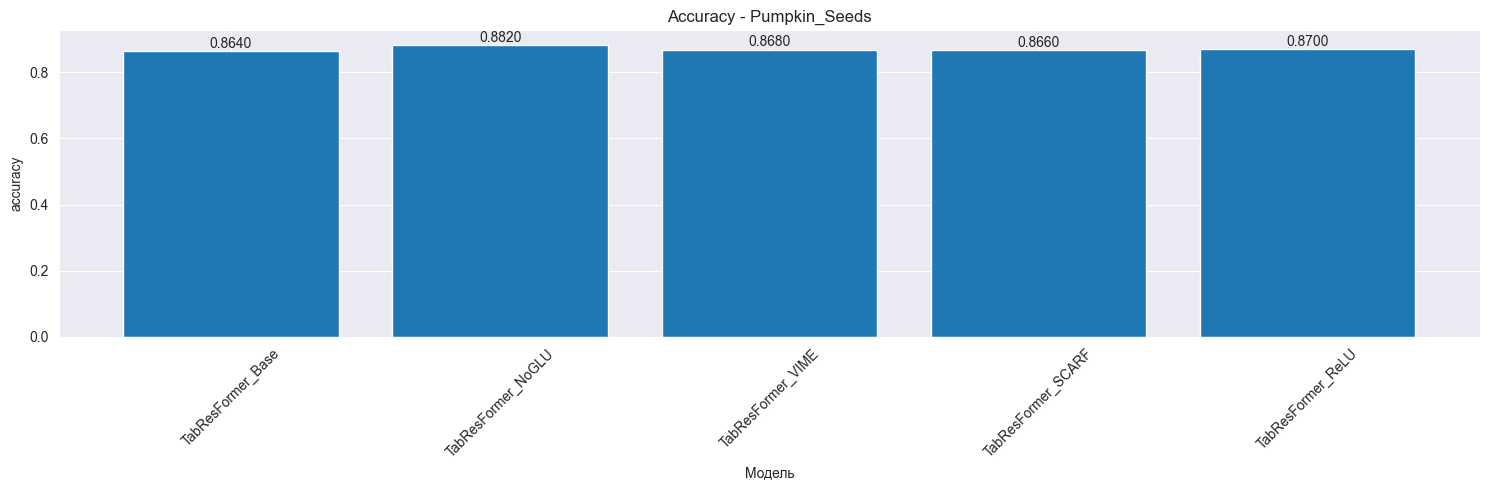

Используем accuracy как основную метрику для wine
Используем mse как основную метрику для houses
Используем accuracy как основную метрику для Pumpkin_Seeds

=== Анализ TabResFormer ===

Датасет: wine
Основная метрика: accuracy
  TabResFormer_Base: 0.0000
  TabResFormer_NoGLU: -0.0161
  TabResFormer_VIME: 0.0027
  TabResFormer_SCARF: -0.0161
  TabResFormer_ReLU: -0.0509

Датасет: houses
Основная метрика: mse
  TabResFormer_Base: 0.0000
  TabResFormer_NoGLU: -0.0029
  TabResFormer_VIME: -0.0091
  TabResFormer_SCARF: -0.0379
  TabResFormer_ReLU: -0.0293

Датасет: Pumpkin_Seeds
Основная метрика: accuracy
  TabResFormer_Base: 0.0000
  TabResFormer_NoGLU: 0.0208
  TabResFormer_VIME: 0.0046
  TabResFormer_SCARF: 0.0023
  TabResFormer_ReLU: 0.0069


In [137]:
def run_experiments_on_specific_datasets(device=None):
    if device is None:
        device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

    datasets = ['wine', 'houses', 'Pumpkin_Seeds']

    all_results = {}

    for dataset_name in datasets:
        print(f"\n=== Обработка датасета: {dataset_name} ===")

        # Проверяем наличие датасета
        if not check_dataset(dataset_name):
            print(f"Датасет {dataset_name} не найден, пропускаем.")
            continue

        # Загружаем датасет
        dataset_data = load_dataset(dataset_name)

        # Предобрабатываем данные
        dataset_info = preprocess_data(dataset_data)

        tabresformer_configs = create_tabresformer_model_configs()

        # Дополняем конфигурации количеством признаков для этого датасета
        for config in tabresformer_configs.values():
            if 'num_continuous' in config and config['num_continuous'] is None:
                config['num_continuous'] = dataset_info['num_features']

        # Запускаем эксперименты с TabResFormer
        results = run_tabresformer_experiments(
            dataset_info=dataset_info,
            model_configs=tabresformer_configs,
            device=device,
            do_pretrain=True,  # Включаем предобучение
            pretrain_epochs=5  # 5 эпох предобучения
        )

        # Визуализируем
        plot_results(results, dataset_info['task_type'], dataset_name)

        all_results[dataset_name] = {
            'task_type': dataset_info['task_type'],
            'results': results
        }

    # Анализируем важность компонентов
    analysis_results = analyze_component_importance(all_results)

    # Выводим результаты анализа
    print("\n=== Анализ TabResFormer ===")
    for dataset_name, summary in analysis_results['dataset_summaries'].items():
        print(f"\nДатасет: {dataset_name}")
        primary_metric = summary['primary_metric']
        relative_performances = summary['relative_performance']

        print(f"Основная метрика: {primary_metric}")
        for model_name, rel_perf in relative_performances.items():
            if 'TabResFormer' in model_name:
                print(f"  {model_name}: {rel_perf:.4f}")

    return all_results

tabresformer_results = run_experiments_on_specific_datasets(device)

1. Для классификации (wine, Pumpkin_Seeds) предобучение с VIME и модификации архитектуры могут быть полезны
Для регрессии (houses) базовая модель без модификаций показывает наилучшие результаты
Эффективность GLU сильно зависит от датасета (полезен для wine и houses, вреден для Pumpkin_Seeds)

2. VIME работает лучше, чем SCARF для всех датасетов
Предобучение дает преимущество в основном для задач классификации
Для регрессии предобучение может ухудшать результаты

3. GELU в целом показывает более стабильные результаты
Для некоторых датасетов (Pumpkin_Seeds) ReLU может быть предпочтительнее